### mediapipe pose

In [1]:
# 라이브러리 설정
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

#### 이미지, 비디오 파일에서 pose detect 수행
- Pose function 옵션
    - static_image_mode(True, False) : True일 경우, human_detector가 모든 이미지에서 호출. 여러 이미지도 작업할 때 True
    - min_detection_confidence(0.0, 1.0) : human_detect_model의 predict가 정답으로 예측하는데 필요한 범위의 최소 감지 신뢰도(기본값은 0.5. detector의 예측 신뢰도가 50% 이상인 경우 양성탐지로 간주)
    - min_tracking_confidence([0.0, 1.0]) : 모델을 추적하는 pose landmark가 유효한 것으로 간주하기 위해 필요한 최소 추적 신뢰도(기본값은 0.5. 신뢰도가 설정값보다 작으면 검출기는 다음 image/frame에서 다시 호출되므로 값이 높으면 rubust해지지만, 수행 시간도 증가
    - model_complexity(0,1,2) : pose landmark model의 복잡도. 기본값은 1. 값이 높을 수록 결과는 정확하지만 수행 시간이 길어짐
    - smooth_landmark(True, False) : 노이즈를 줄이기 위해 프레임의 포즈 랜드마크가 필터링. static_image_mode 작동 시에만 사용가능, 기본값 True

In [2]:
# mediapipe pose class를 초기화
mp_pose = mp.solutions.pose 

# pose detect function에 image detect=True, 최소감지신뢰도 = 0.3, 모델 복잡도 =2를 준다.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
 
# mediapipe의 drawing class를 초기화
mp_drawing = mp.solutions.drawing_utils

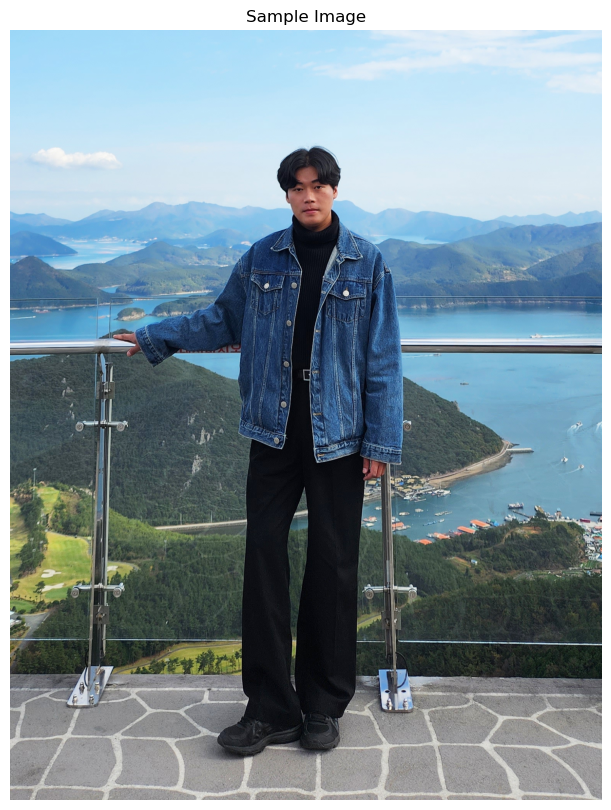

In [3]:
# 이미지 읽어오기
sample_img = cv2.imread('img/sample.jpg') 
plt.figure(figsize = [10, 10]) 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [4]:
# pose detect 수행
# 이미지 파일은 RGB색상 형식. opencv는 BGR 순서로 저장되고, matplotlib은 RGB 순서로 저장되기때문에 cv2.COLOR_BGR2RGB로 BGR을 RGB 값으로 변경
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

if results.pose_landmarks:
    for i in range(2):        
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')

NOSE:
x: 0.5057415
y: 0.21945944
z: -0.24106783
visibility: 0.99994326

LEFT_EYE_INNER:
x: 0.5164429
y: 0.20658612
z: -0.22853209
visibility: 0.9998431



In [5]:
# 원본 이미지의 너비&높이를 이용하여 위에 나타낸 코와 왼쪽눈 안쪽의 정규화된 랜드마크를 원래 크기로 변환
image_height, image_width, _ = sample_img.shape
 
if results.pose_landmarks:
    
    for i in range(2):
        
        print(f'{mp_pose.PoseLandmark(i).name}:') 
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 776.8189086914062
y: 438.9188885688782
z: -370.2801818847656
visibility: 0.9999432563781738

LEFT_EYE_INNER:
x: 793.2562866210938
y: 413.17224502563477
z: -351.0252914428711
visibility: 0.9998431205749512



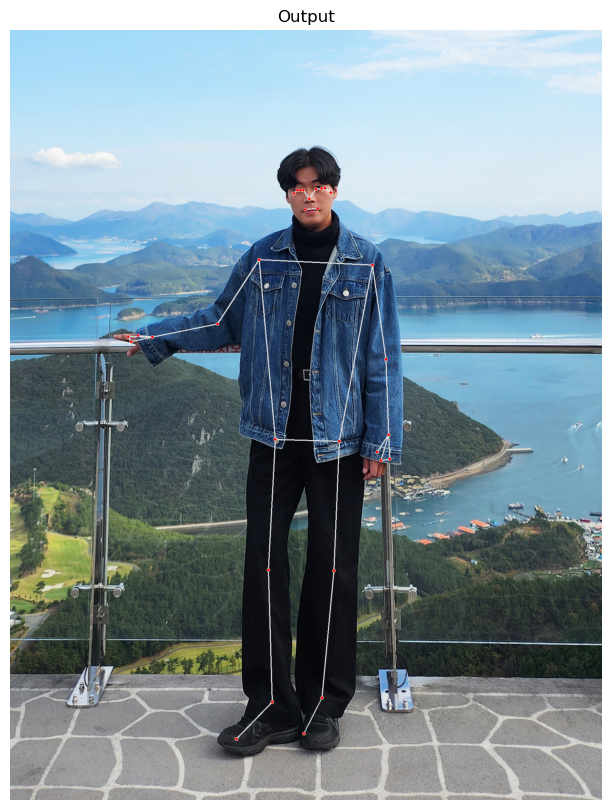

In [6]:
# 랜드마크를 그릴 사진을 COPY한다.
img_copy = sample_img.copy()
 
# 랜드마크를 찾는다.
if results.pose_landmarks:    
    
    # sample image에 landmark를 그린다.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # figure의 크기를 설정한다.
    fig = plt.figure(figsize = [10, 10])
 
    # landmark가 draw된 image를 보여주기 전에 BGR TO RGB를 위해 copy_image의 순서를 반대로 변형해준다. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

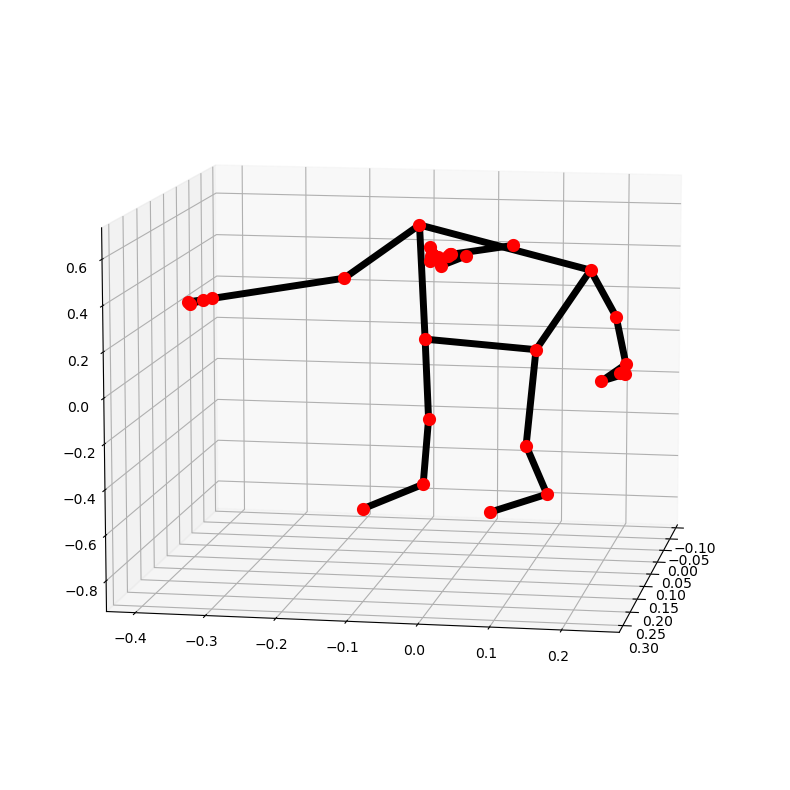

In [7]:
# 3차원으로 pose의 landmark의 위치를 확인
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

### pose detection function 만들기

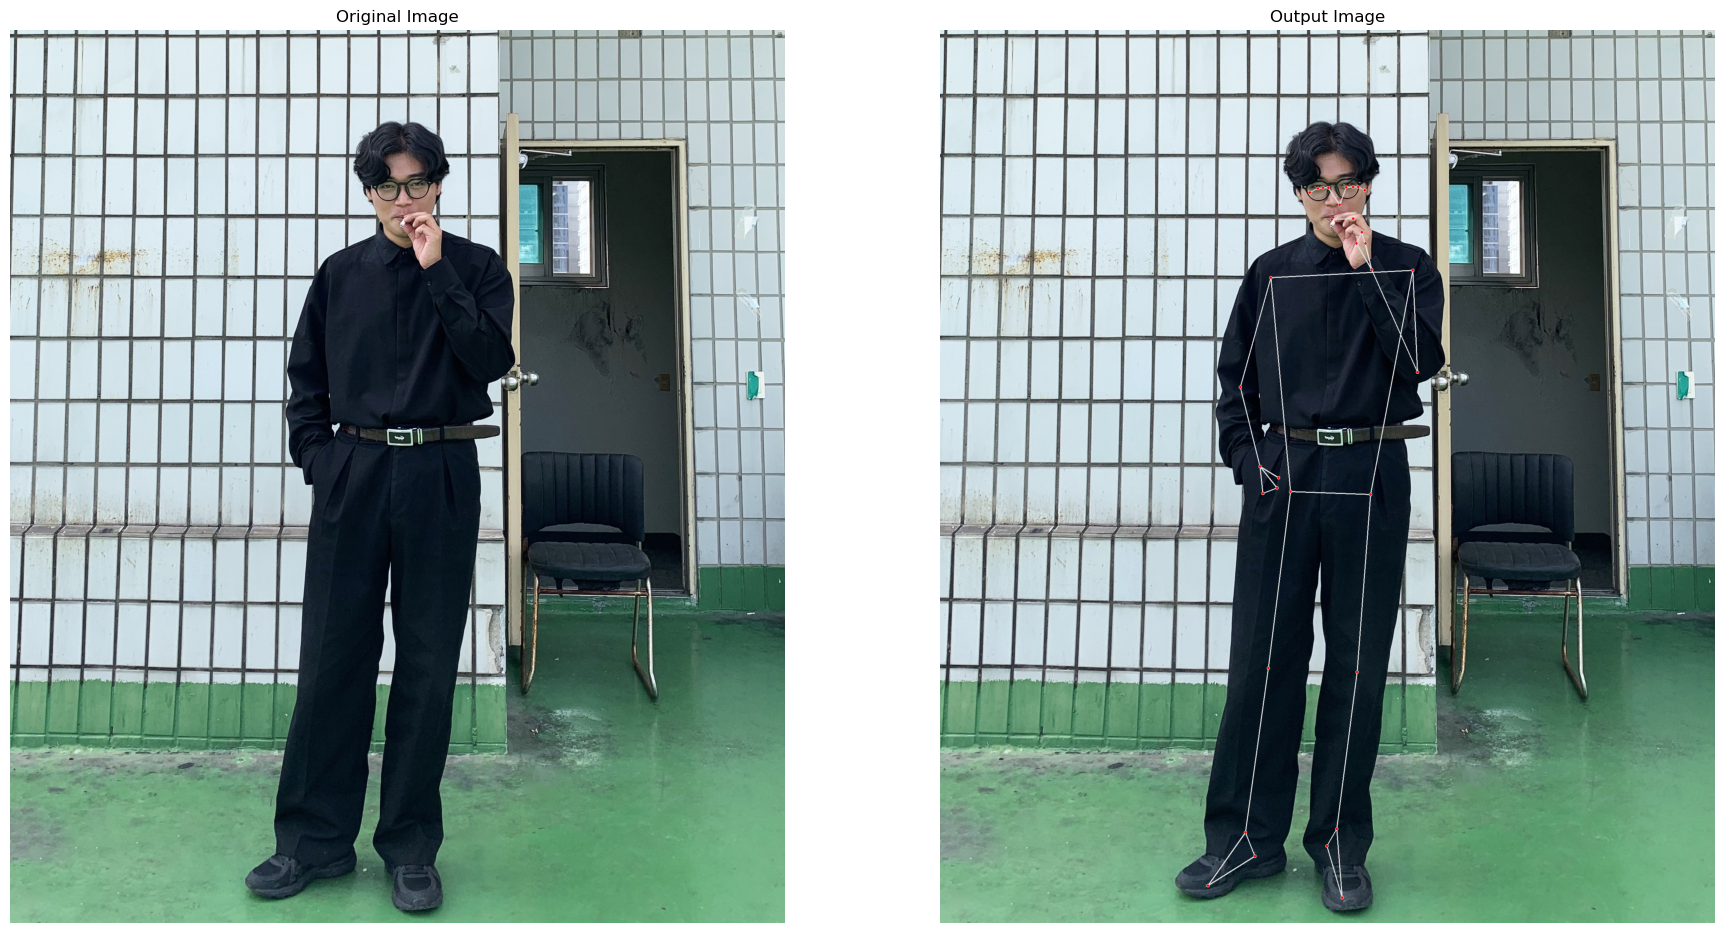

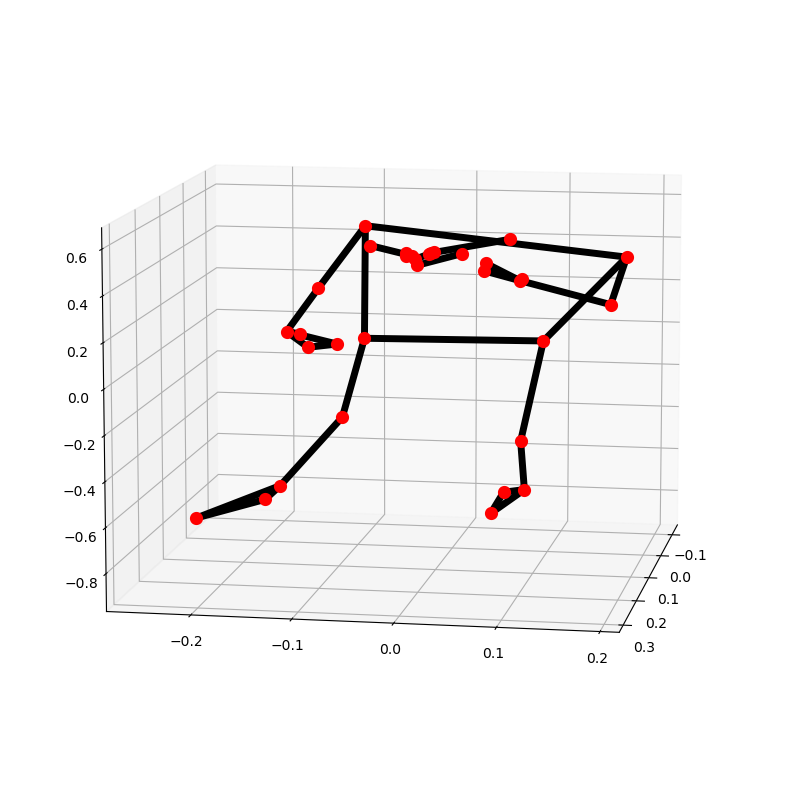

In [8]:
def detectPose(image, pose, display=True):
    # 예시이미지 copy하기
    output_image = image.copy()    
    # 컬러 이미지 BGR TO RGB 변환
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # pose detection 수행
    results = pose.process(imageRGB)
    # input image의 너비&높이 탐색
    height, width, _ = image.shape
    # detection landmarks를 저장할 빈 list 초기화
    landmarks = []
    # landmark가 감지 되었는지 확인
    if results.pose_landmarks:
      # landmark 그리기
      mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
      # 감지된 landmark 반복
      for landmark in results.pose_landmarks.landmark:
        # landmark를 list에 추가하기
        landmarks.append((int(landmark.x * width), int(landmark.y * height), (landmark.z * width)))
    # 오리지널 image와 pose detect된 image 비교
    if display:
      # 오리지널 & 아웃풋 이미지 그리기
      plt.figure(figsize=[22,22])
      plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
      plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
      # 3D 랜드마크 나타내기
      mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    # 그렇지 않다면, output_image 와 landmark return한다
    else:
      return output_image, landmarks
# pose detection function start
image = cv2.imread('img/sample2.jpg')
detectPose(image, pose, display=True)

### 영상에서 포즈 감지

In [1]:
import cv2
import mediapipe as mp
from time import time

mp_pose = mp.solutions.pose

# 비디오에서 포즈를 감지하기 위한 Pose 함수 설정.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)
# 디스크에 저장된 비디오로부터 읽기 위해 VideoCapture 객체 초기화.
video = cv2.VideoCapture('video/sample.mp4')
# 이전 프레임의 시간을 저장할 변수 초기화.
time1 = 0
# 비디오가 성공적으로 접근될 때까지 반복.
while video.isOpened():    
    # 한 프레임 읽기
    """ret 또는 이 경우에 사용된 ok: 비디오 프레임을 성공적으로 읽었는지의 여부를 나타내는 불리언 값입니다. 프레임이 성공적으로 읽혔다면 True, 아니면 False를 반환
    frame: 읽혀진 비디오 프레임의 이미지 데이터를 나타내는 NumPy 배열입니다. 만약 ret가 True라면, frame에는 유효한 프레임 데이터가 포함
    read() 메서드는 호출될 때마다 비디오 스트림에서 다음 프레임을 캡처하려고 시도하고, 이러한 두 개의 값을 튜플 형태로 반환"""
    ok, frame = video.read()    
    # 프레임이 제대로 읽히지 않았다면,
    if not ok:
        # 루프 종료.
        break    
    # 자연스러운 시각화를 위해 프레임을 수평으로 뒤집기.
    frame = cv2.flip(frame, 1)    
    # 프레임의 너비와 높이 가져오기.
    """_ (언더스코어)는 파이썬에서 일반적으로 무시할 값을 할당할 때 사용되는 관례적인 표현.
    frame.shape는 튜플을 반환하는데, 이 튜플에는 보통 (높이, 너비, 채널 수)의 세 가지 값이 들어 있음
    여기서 _는 이미지의 채널 수를 받기 위해 사용되지만, 이 코드의 경우 채널 수는 필요하지 않으므로 해당 값을 _에 할당하여 명시적으로 무시
    이는 코드를 읽는 사람에게 이 특정 변수가 프로그램에서 사용되지 않을 것임을 알려주는 역할을 합니다."""
    frame_height, frame_width, _ = frame.shape    
    # 종횡비를 유지하며 프레임 크기 조정.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # 포즈 랜드마크 감지 수행.
    """여기서 detectPose함수는 output_image, landmarks 두가지를 반환함
    이 코드는 영상에서 스켈레톤 데이터만 감지하는데 사용하고 있기 떄문에 output_image만 사용중.
    
    landmarks는 각 랜드마크의 위치 데이터를 포함하며, 포즈 감지 관련 작업에 활용
    예를 들어, 랜드마크 데이터를 분석하여 특정 포즈를 인식하거나, 운동 동작을 평가하는 데 사용
    """
    frame, _ = detectPose(frame, pose_video, display=False)
    
    # 현재 프레임의 시간을 설정.
    time2 = time()
    
    # 이전 프레임과 현재 프레임 사이의 시간 차이가 0보다 큰지 확인하여 0으로 나누는 것을 방지.
    if (time2 - time1) > 0:
    
        # 초당 프레임 수 계산.
        frames_per_second = 1.0 / (time2 - time1)
        
        # 계산된 초당 프레임 수를 프레임에 표시.
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # 이전 프레임 시간을 현재 프레임 시간으로 업데이트.
    # 다음 반복에서 현재 프레임이 이전 프레임이 됨.
    time1 = time2
    
    # 프레임을 화면에 표시.
    cv2.imshow('Pose Detection', frame)
    
    # 키가 눌릴 때까지 대기
    # 눌린 키의 ASCII 코드 가져오기
    k = cv2.waitKey(1) & 0xFF
    
    # 'ESC'가 눌렸는지 확인
    if(k == 27):
        # 루프 종료.
        break

# VideoCapture 객체 해제
video.release()

# 모든 창 닫기.
cv2.destroyAllWindows()


KeyboardInterrupt

